# Table of contents

1. [Data overview](#data_overview)    
    1. [Performance of the top classifiers](#performance)
    2. [Finding the best subset](#finding)      
2. [Reconstructing the top models](#reconstructing)    
    1. [ROC curves](#roc_curves)    
3. [Supplementary data](#supplementary)    
    1. [Correlations](#correlations)    
    2. [Comparing classifiers](#comparing)   
    3. [Performance of the top classifiers](#top_classifiers)
    4. [Docking scores and performance increment](#docking)    
    5. [Top descriptors](#top_descriptors)    
    
<a id='scoring_metrics'></a>
## Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read data
data = pd.read_csv('data.csv')

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Descriptors
descriptors_list = list(descriptors.columns[2:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']
trainset = descriptors_list + docking_list

# Test metrics
scoring_metrics = ['test_accuracy','test_precision','test_recall','test_f1','test_f2',
                   'test_geometric_mean','test_roc_auc']
columns = ['activity_label', 'model', 'random_state', scoring_metrics] + trainset

<a id='data_overview'></a>
## Data overview

In [3]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data.csv.gz', compression='gzip')

model_list = scores_data['model'].unique()
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']
test_metrics = selected + ['test_mean']
train_metrics = [metric.replace('test', 'train') for metric in test_metrics]

scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
313,0.687540,0.333471,0.665642,0.441712,0.551862,0.675851,0.679020,f_activity,KNeighborsClassifier,0,0,0,1,1,0,0,0,0,0,0.635578
2372,0.683889,0.329452,0.665823,0.438286,0.549731,0.675075,0.677749,f_activity,KNeighborsClassifier,0,1,0,1,1,0,0,0,0,0,0.634185
1946,0.689127,0.332555,0.656939,0.438801,0.546274,0.674372,0.677490,f_activity,KNeighborsClassifier,1,0,0,1,1,0,0,0,0,0,0.632712
597,0.694762,0.336235,0.645020,0.440257,0.542806,0.673417,0.675698,f_activity,KNeighborsClassifier,1,1,1,0,0,1,1,1,0,0,0.630640
146,0.693651,0.335213,0.643214,0.437713,0.539751,0.671449,0.674721,f_activity,KNeighborsClassifier,1,1,1,0,0,1,1,0,0,0,0.628640


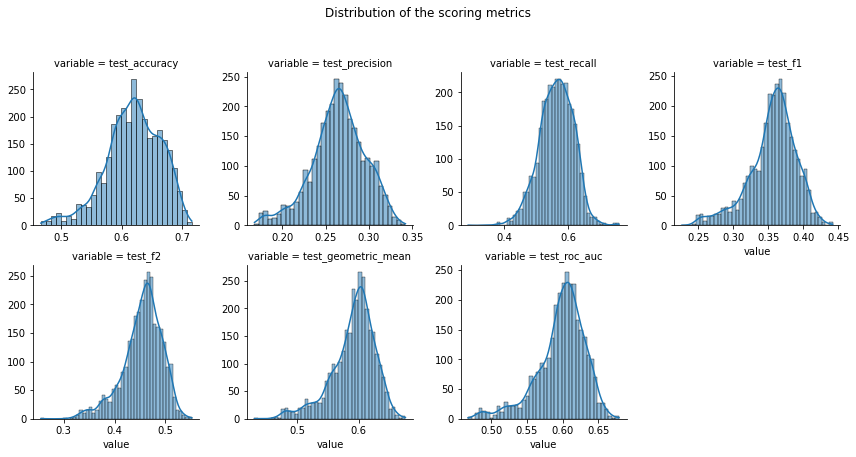

In [4]:
tmp = pd.melt(scores_data, value_vars=scoring_metrics)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of the scoring metrics', y=1.05)
plt.show()

<a id='performance'></a>
### Performance of the top classifiers

Text(0.5, 1.05, 'Model performance by scoring metric')

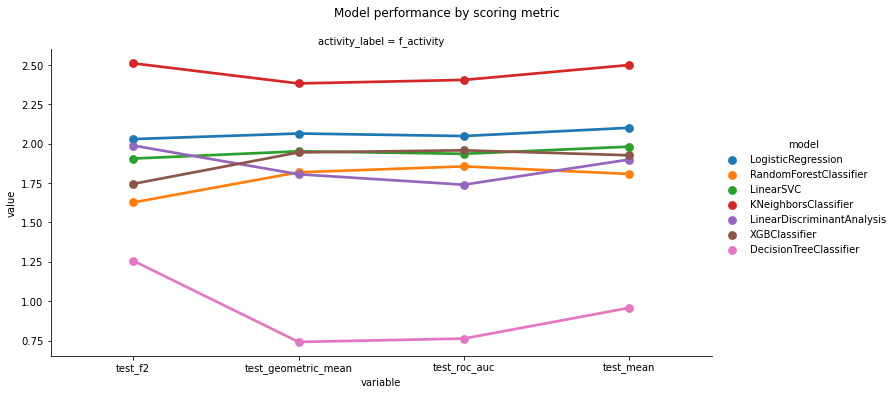

In [5]:
from sklearn.preprocessing import StandardScaler

df = scores_data[['activity_label','model',*test_metrics]].copy()
df[test_metrics] = StandardScaler().fit_transform(df[test_metrics])
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), 
              id_vars=['activity_label','model'], value_vars=test_metrics)
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', 
            hue='model', row='activity_label', aspect=2, order=test_metrics, hue_order=model_list)
plt.suptitle('Model performance by scoring metric', y=1.05)

<a id='finding'></a>
### Finding the best subset

In [6]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}
activity_label = 'f_activity'

for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    model_name = row['model']
    best_subset[model_name] = [descriptor for descriptor in trainset if row[descriptor]]
    print(model_name, best_subset[model_name])

KNeighborsClassifier ['TPSA', 'LabuteASA']
LogisticRegression ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP', 'rfscore_qvina']
LinearSVC ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'LabuteASA', 'MolLogP', 'rfscore_qvina']
XGBClassifier ['NumRotatableBonds', 'NumHDonors', 'TPSA', 'LabuteASA', 'plants']
LinearDiscriminantAnalysis ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA', 'MolLogP', 'qvina', 'rfscore_qvina']
RandomForestClassifier ['NumRotatableBonds', 'NumHDonors', 'TPSA', 'LabuteASA', 'plants']
DecisionTreeClassifier ['NumRotatableBonds', 'NumHDonors', 'LabuteASA', 'qvina']


<a id='reconstructing'></a>
## Reconstructing the top models

In [7]:
def get_model_by_name(model_name):
    if model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV is used for applying probability transformation 
        # on top of the SVC outputs, so we can plot the ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    elif model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=40, max_depth=6, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='reg:logistic', n_estimators=40, 
            max_depth=3, eta=0.2, random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        from sklearn.tree import DecisionTreeClassifier
        return DecisionTreeClassifier(max_depth=6, random_state=13)
    elif model_name == 'LinearDiscriminantAnalysis':
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        return LinearDiscriminantAnalysis(solver='svd')
    else:
        return None

In [8]:
def train_test_scores(X_train, X_test, y_train, y_test, model_fitted):
    from sklearn.metrics import fbeta_score
    from imblearn.metrics import geometric_mean_score
    
    scores_list = []
    y_pred_test = model_fitted.predict(X_test)
    y_pred_train = model_fitted.predict(X_train)
    
    scores_list.append(fbeta_score(y_test, y_pred_test, beta=2))       # test_f2
    scores_list.append(fbeta_score(y_train, y_pred_train, beta=2))     # train_f2
    scores_list.append(geometric_mean_score(y_test, y_pred_test))      # test_geometric_mean
    scores_list.append(geometric_mean_score(y_train, y_pred_train))    # train_geometric_mean
    return scores_list

def plot_train_test_roc(axis, X_train, X_test, y_train, y_test, model_fitted, model_name):
    from sklearn.metrics import roc_curve, auc
    # Test ROC
    y_proba_test = model_fitted.predict_proba(X_test)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test[:,1])
    test_auc = auc(fpr_test, tpr_test)
    axis[0].plot(fpr_test, tpr_test, label=f'{model_name}: {test_auc:>.3f}')

    # Training ROC
    y_proba_train = model_fitted.predict_proba(X_train)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train[:,1])
    train_auc = auc(fpr_train, tpr_train)
    axis[1].plot(fpr_train, tpr_train, label=f'{model_name}: {train_auc:>.3f}')
    
    return test_auc, train_auc
    
def get_mean_scores(X, y, scaler, model, model_name, axis):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    from sklearn.model_selection import train_test_split
        
    pipe = make_pipeline(SMOTE(random_state=42), scaler, model)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    model_fitted = pipe.fit(X_train, y_train)
    # Test and training scores
    scores_list = train_test_scores(X_train, X_test, y_train, y_test, model_fitted)
    
    # Plot mean ROC curve
    test_auc, train_auc = plot_train_test_roc(axis, X_train, X_test, y_train, y_test, 
                                              model_fitted, model_name)
    # Append mean AUC
    scores_list.append(test_auc)
    scores_list.append(train_auc)
    scores_list.append(model_name)
    return scores_list

<a id='roc_curves'></a>
### ROC curves

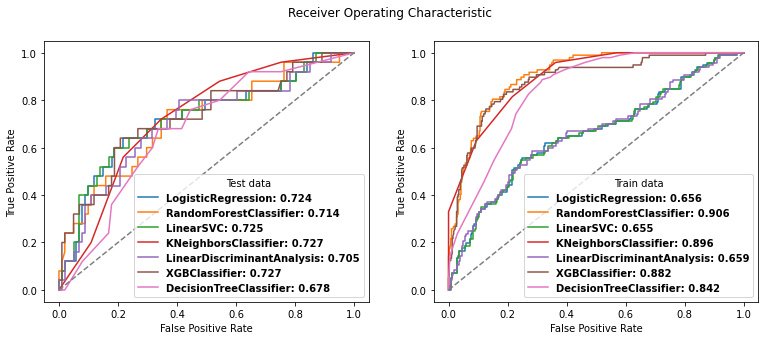

,test_f2,train_f2,test_geometric_mean,train_geometric_mean,test_roc_auc,train_roc_auc,model,test_mean,train_mean
0,0.555556,0.493827,0.680128,0.633337,0.723564,0.655701,LogisticRegression,0.653083,0.594288
1,0.588235,0.752688,0.685926,0.825336,0.714257,0.905618,RandomForestClassifier,0.662806,0.827881
2,0.555556,0.490196,0.680128,0.633236,0.725149,0.654703,LinearSVC,0.653611,0.592712
3,0.588235,0.712996,0.685926,0.799132,0.726931,0.896165,KNeighborsClassifier,0.667031,0.802765
4,0.562914,0.493197,0.671632,0.622294,0.704950,0.659385,LinearDiscriminantAnalysis,0.646499,0.591625
5,0.566667,0.731047,0.676625,0.811741,0.726535,0.882275,XGBClassifier,0.656609,0.808354
6,0.548387,0.709516,0.651274,0.776088,0.677624,0.842112,DecisionTreeClassifier,0.625762,0.775905


In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))
# List of scores for the top models
scores_list = []

for model_name in model_list:
    subset = best_subset[model_name]
    y = data[activity_label]
    X = data[subset]
    scaler = StandardScaler()
    model = get_model_by_name(model_name)
    model_scores = get_mean_scores(X, y, model, model_name, scaler, axis=ax)
    scores_list.append(model_scores)

columns = ['test_f2', 'train_f2', 'test_geometric_mean', 'train_geometric_mean', 
           'test_roc_auc', 'train_roc_auc', 'model']
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics[:-1]].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics[:-1]].mean(axis=1)

for i in range(2):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
font_prop = {'weight':'bold'}
ax[0].legend(title='Test data', prop=font_prop)
ax[1].legend(title='Train data', prop=font_prop)

plt.suptitle('Receiver Operating Characteristic')
#plt.savefig('figures/roc_curve.png', dpi=128)
plt.show()

top_scores

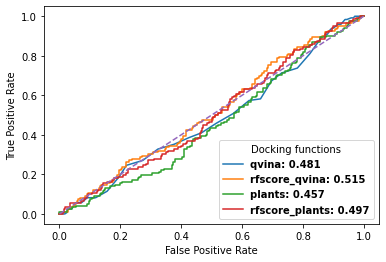

In [13]:
from sklearn.metrics import roc_curve, auc

# Plotting ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    plt.plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')
    
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
font_prop = {'weight':'bold'}
plt.legend(title='Docking functions', loc='lower right', prop=font_prop)

<a id='supplementary'></a>
## Supplementary data
<a id='comparing'></a>
### Comparing classifiers

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(scores_data.groupby(['model','activity_label']).describe())

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_activity             437.0  0.593533  0.026637   
KNeighborsClassifier       f_activity             437.0  0.636695  0.029022   
LinearDiscriminantAnalysis f_activity             437.0  0.593873  0.041404   
LinearSVC                  f_activity             437.0  0.595495  0.042183   
LogisticRegression         f_activity             437.0  0.598529  0.042571   
RandomForestClassifier     f_activity             437.0  0.654037  0.030491   
XGBClassifier              f_activity             437.0  0.661697  0.029706   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.504127  0.577222  0.598175   
KNeighborsClassifier       f_activity      0.541111  0.620397  0.640317   
LinearDiscriminantAnalysis f_activity      0.466032  0.575000  0.597857   
LinearSVC                  f_activity      0.467381  0.576270  0.600317   
LogisticRegression         f_activity      0.471349  0.579524  0.605556   
RandomForestClassifier     f_activity      0.549762  0.634841  0.658968   
XGBClassifier              f_activity      0.545238  0.647302  0.667063   

                                                              test_precision  \
                                                75%       max          count   
model                      activity_label                                      
DecisionTreeClassifier     f_activity      0.612222  0.663016          437.0   
KNeighborsClassifier       f_activity      0.656667  0.701667          437.0   
LinearDiscriminantAnalysis f_activity      0.621587  0.679127          437.0   
LinearSVC                  f_activity      0.623492  0.683333          437.0   
LogisticRegression         f_activity      0.627143  0.686667          437.0   
RandomForestClassifier     f_activity      0.676429  0.716190          437.0   
XGBClassifier              f_activity      0.684206  0.715556          437.0   

                                                                         \
                                               mean       std       min   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.248322  0.016687  0.192936   
KNeighborsClassifier       f_activity      0.271751  0.029591  0.182105   
LinearDiscriminantAnalysis f_activity      0.254150  0.029021  0.167993   
LinearSVC                  f_activity      0.254712  0.029513  0.168044   
LogisticRegression         f_activity      0.255700  0.030076  0.168206   
RandomForestClassifier     f_activity      0.282689  0.027225  0.196879   
XGBClassifier              f_activity      0.285410  0.026773  0.194239   

                                                                         \
                                                25%       50%       75%   
model                      activity_label                                 
DecisionTreeClassifier     f_activity      0.237191  0.250004  0.261068   
KNeighborsClassifier       f_activity      0.253413  0.275825  0.291817   
LinearDiscriminantAnalysis f_activity      0.242403  0.258071  0.272079   
LinearSVC                  f_activity      0.242465  0.258809  0.272955   
LogisticRegression         f_activity      0.241702  0.260140  0.274464   
RandomForestClassifier     f_activity      0.266381  0.284519  0.303575   
XGBClassifier              f_activity      0.272783  0.288270  0.304902   

                                                    test_recall            \
                                                max       count      mean   
model                      activity_label  

<a id='top_classifiers'></a>
### Performance of the top classifiers

Text(0.5, 1.05, 'Model performance by scoring metric')

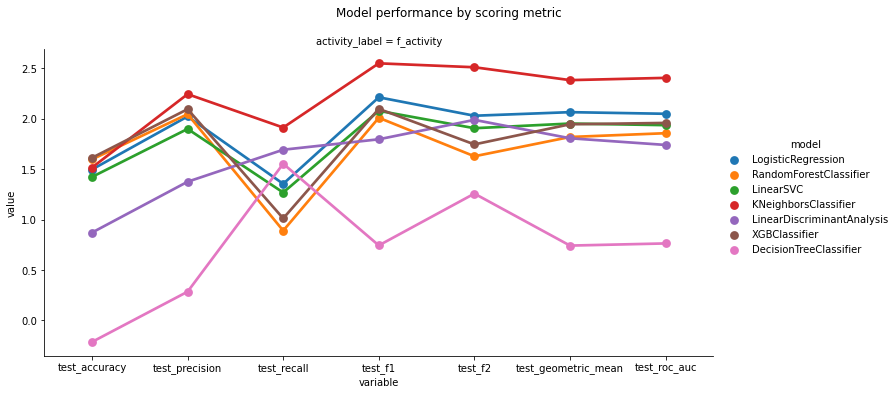

In [9]:
df = scores_data[['activity_label','model',*scoring_metrics]].copy()
df[scoring_metrics] = StandardScaler().fit_transform(df[scoring_metrics])
top = pd.melt(df.groupby(['activity_label', 'model']).head(1), 
              id_vars=['activity_label','model'], value_vars=scoring_metrics)
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', 
            hue='model', row='activity_label', aspect=2, order=scoring_metrics, hue_order=model_list)
plt.suptitle('Model performance by scoring metric', y=1.05)

<a id='docking'></a>
### Docking scores and performance increment

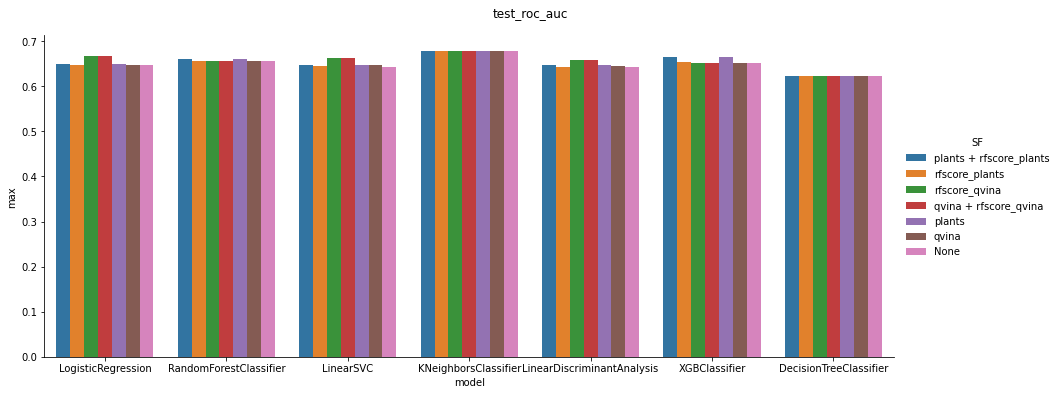

In [15]:
'''
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]
'''

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0'
                      ).groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0'
                       ).groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

sns.catplot(kind='bar', data=df, x='model', y='max', hue='SF', orient='v', aspect=2.5, order=model_list)
plt.suptitle('test_roc_auc', y=1.05)
plt.show()

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.

<a id='top_descriptors'></a>
### Top descriptors

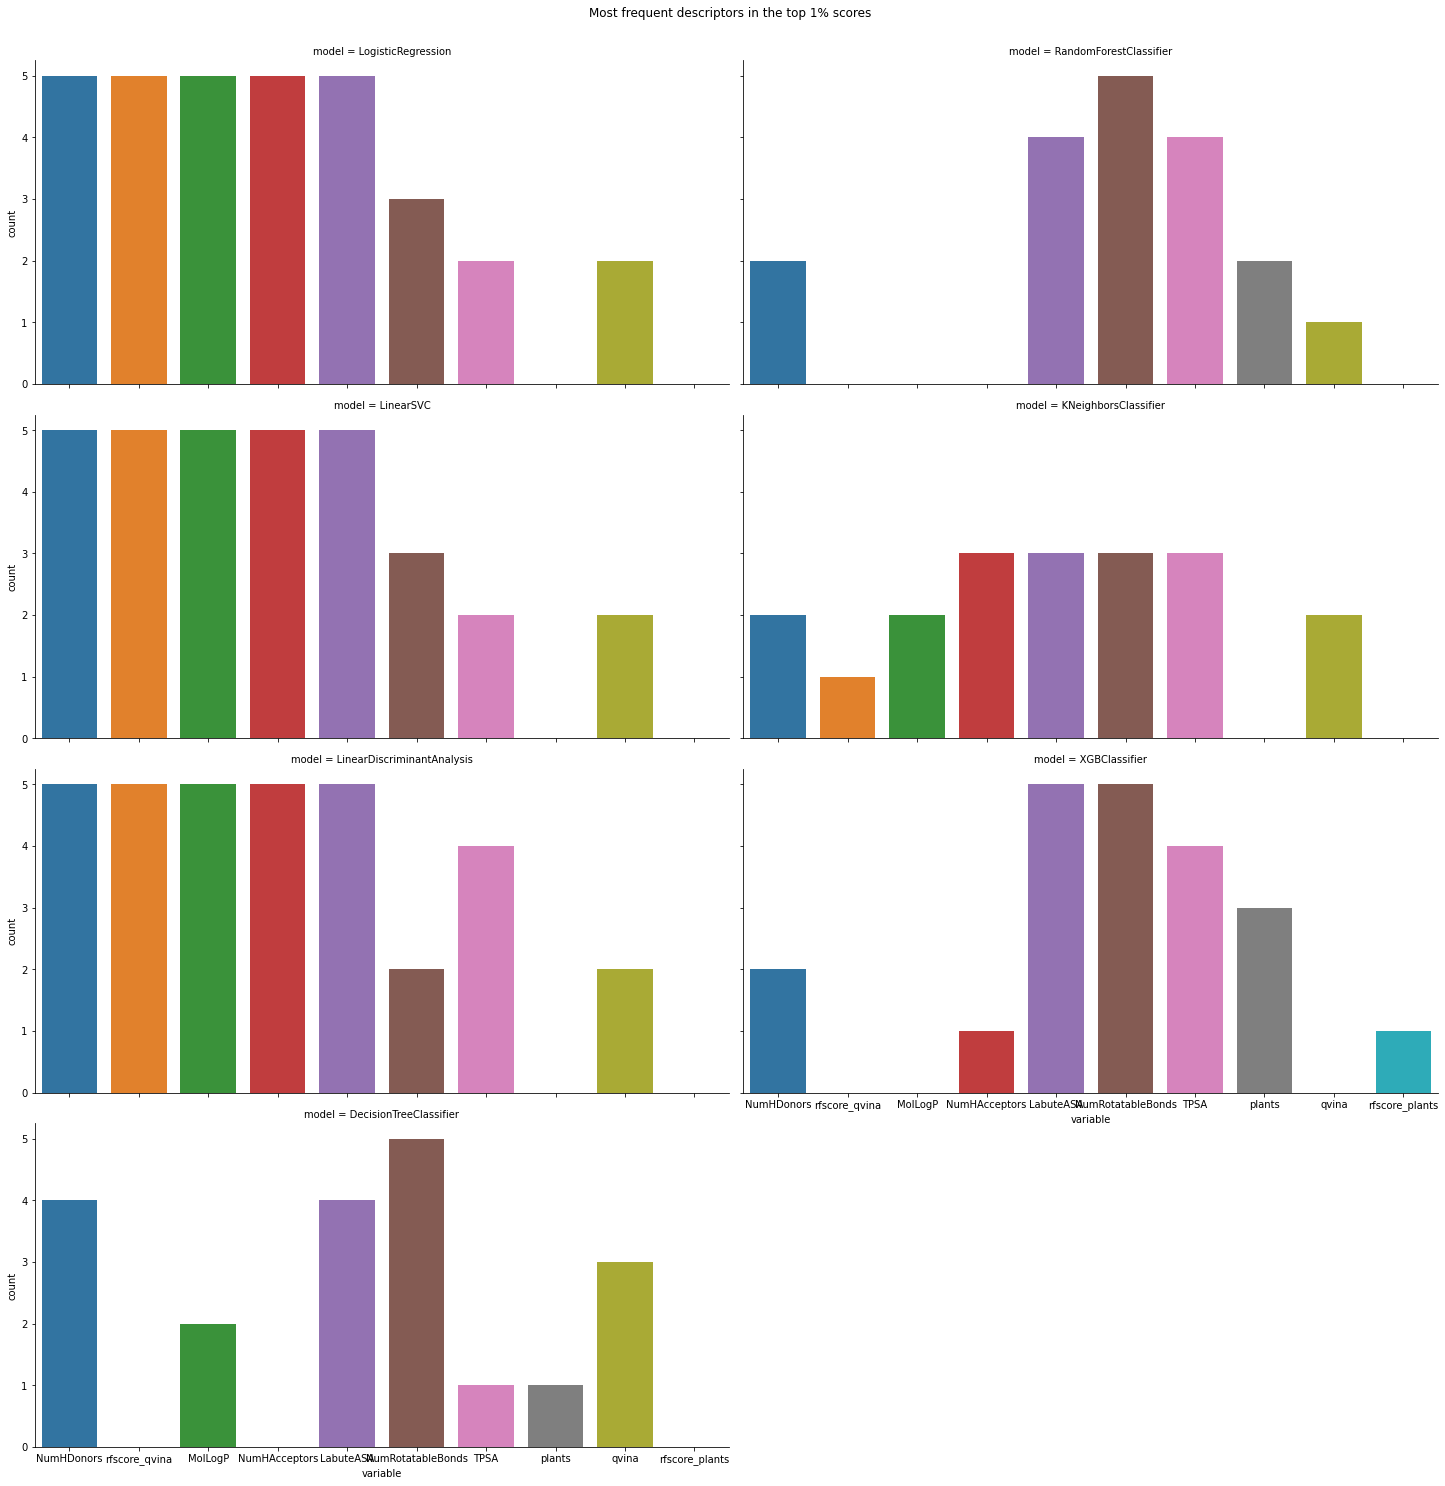

In [16]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=['activity_label','model',*test_metrics], value_vars=trainset, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', 
                col_order=model_list, col_wrap=2, aspect=2)

# Set title
plt.suptitle('Most frequent descriptors in the top 1% scores', y=1.02)
plt.show()